# Python Tutorial, Part 2: Advanced Plotting
## Making synoptic plots using archived GFS model analyses from NCEI THREDDS server

#### Created by Massey Bartolini, last updated 15 Nov 2020
<hr/>

### Overview of steps to make a plot 
<ol>
    <li> Get data </li>
    <li> Make calculation (if field not already available) </li>
    <li> Make a plot </li> 
    <li> Plot geography layers and data </li>
    <li> Add labels and legend </li>
</ol>

### General python package requirements
<ul>
    <li> numpy (array handing, calculations) </li>
    <li> matplotlib (general plotting) </li>
    <li> datetime (handling dates and times) </li>
    <li> xarray (data access and viewing of multidimensional 3D+ data) </li>
    <li> cartopy (geographic plotting), need v0.18+ here  </li> 
    <li> metpy (meteorology calculations) </li>
</ul>

In [1]:
#List of python imports
import xarray as xr
from datetime import datetime, timedelta
import matplotlib as mpl
#mpl.use('Agg') #use different backend to prevent having to open an X-window (uncomment this if using as a python script instead of a jupyter notebook)
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES
import metpy.calc as mpcalc
from metpy.units import units
import os

In [2]:
#Accessing GFS analysis data from NCEI THREDDS server

#Select date to view (some interesting dates below)
model_init=datetime(2012,10,29,18) #Initialization time of model in UTC (YYYY, MM, DD, HH)
#model_init=datetime(2017,3,15,0)  #Initialization time of model in UTC (YYYY, MM, DD, HH)
#model_init=datetime(2016,1,23,12) #Initialization time of model in UTC (YYYY, MM, DD, HH)
#model_init=datetime(2019,12,2,12) #Initialization time of model in UTC (YYYY, MM, DD, HH)
#model_init=datetime(2019,3,13,12) #Initialization time of model in UTC (YYYY, MM, DD, HH)
#model_init=datetime(2011,4,27,18) #Initialization time of model in UTC (YYYY, MM, DD, HH)
#model_init=datetime(2012,6,29,18) #Initialization time of model in UTC (YYYY, MM, DD, HH)


#Use format-string (f-string) notation to update the url automatically using model_init above
#Also using strftime formatting syntax here (the colon and percentage signs after the date variable, "model_init :%Y%m")
#to retrieve just the parts of the date needed for the url (see https://strftime.org/)
data_url=f'https://www.ncei.noaa.gov/thredds/dodsC/model-gfs-g4-anl-files-old/{model_init:%Y%m}/{model_init:%Y%m%d}/gfsanl_4_{model_init:%Y%m%d}_{model_init:%H%M}_000.grb2'

#Recent GFS analyses (last few months) are in a different directory
#model_init=datetime(2020,10,7,18) #Initialization time of model in UTC (YYYY, MM, DD, HH)
#data_url=f'https://www.ncei.noaa.gov/thredds/dodsC/model-gfs-g4-anl-files/{model_init:%Y%m}/{model_init:%Y%m%d}/gfs_4_{model_init:%Y%m%d}_{model_init:%H%M}_000.grb2'

#Open a connection to a remote server's data (doesn't download any data yet until you specify a variable to load)
ds=xr.open_dataset(data_url)

In [3]:
#View dataset summary before downloading some variables
#xarray package has exceptionally nice handing of multi-dimensional data: 
#with Datasets (contains all data in file), DataArrays (individual variables), data coordinates, 
#dimensions, and associated attributes (metadata)
#See http://xarray.pydata.org/en/stable/data-structures.html
#This makes it really easy to view, subset, and do calculations on data compared to older python packages,
#with fewer coding mistakes!
ds

<xarray.Dataset>
Dimensions:                                                                   (altitude_above_msl: 3, depth_below_surface_layer: 4, depth_below_surface_layer_bounds_1: 2, height_above_ground: 1, height_above_ground1: 2, height_above_ground2: 1, height_above_ground3: 3, height_above_ground4: 3, height_above_ground_layer: 1, height_above_ground_layer1: 1, height_above_ground_layer1_bounds_1: 2, height_above_ground_layer_bounds_1: 2, isobaric: 1, isobaric1: 6, isobaric2: 21, isobaric3: 26, isobaric4: 2, isobaric5: 25, lat: 361, lon: 720, potential_vorticity_surface: 2, pressure_difference_layer: 1, pressure_difference_layer1: 1, pressure_difference_layer1_bounds_1: 2, pressure_difference_layer2: 2, pressure_difference_layer2_bounds_1: 2, pressure_difference_layer_bounds_1: 2, sigma: 1, sigma_layer: 4, sigma_layer_bounds_1: 2, time: 1)
Coordinates:
  * lat                                                                       (lat) float32 ...
  * lon                                                                       (lon) float32 ...
    reftime                                                                   datetime64[ns] ...
  * time                                                                      (time) datetime64[ns] ...
  * height_above_ground_layer                                                 (height_above_ground_layer) float32 ...
  * sigma                                                                     (sigma) float32 ...
  * height_above_ground                                                       (height_above_ground) float32 ...
  * depth_below_surface_layer                                                 (depth_below_surface_layer) float32 ...
  * pressure_difference_layer                                                 (pressure_difference_layer) float32 ...
  * isobaric                                                                  (isobaric) float32 ...
  * height_above_ground1                                                      (height_above_ground1) float32 ...
  * height_above_ground2                                                      (height_above_ground2) float32 ...
  * isobaric1                                                                 (isobaric1) float32 ...
  * isobaric2                                                                 (isobaric2) float32 ...
  * altitude_above_msl                                                        (altitude_above_msl) float32 ...
  * height_above_ground3                                                      (height_above_ground3) float32 ...
  * height_above_ground_layer1                                                (height_above_ground_layer1) float32 ...
  * pressure_difference_layer1                                                (pressure_difference_layer1) float32 ...
  * isobaric3                                                                 (isobaric3) float32 ...
  * isobaric4                                                                 (isobaric4) float32 ...
  * pressure_difference_layer2                                                (pressure_difference_layer2) float32 ...
  * sigma_layer                                                               (sigma_layer) float32 ...
  * height_above_ground4                                                      (height_above_ground4) float32 ...
  * potential_vorticity_surface                                               (potential_vorticity_surface) float32 ...
  * isobaric5                                                                 (isobaric5) float32 ...
Dimensions without coordinates: depth_below_surface_layer_bounds_1, height_above_ground_layer1_bounds_1, height_above_ground_layer_bounds_1, pressure_difference_layer1_bounds_1, pressure_difference_layer2_bounds_1, pressure_difference_layer_bounds_1, sigma_layer_bounds_1
Data variables:
    LatLon_Projection                                                         int32 ...
    height_above_ground_layer_bounds  

### Advanced plotting, using MetPy to calculate variables not in GFS standard dataset

In [4]:
#First example: plot pressure level temperature, temperature advection, geopotential heights, and wind barbs

#Heights, winds, and temperature are available variables in the dataset, 
#will need to calculate temperature advection (using MetPy)

plevel=850 #desired pressure level (hPa)
lonoffset=360 #Note that THREDDS server hosts GFS data in degrees east
latmin=20
latmax=55
lonmin=-135+lonoffset
lonmax=-55+lonoffset 
tstep=0 #Forecast hour time step (pretty simple for analysis data with only one time index)

varname='u-component_of_wind_isobaric'
uwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='v-component_of_wind_isobaric'
vwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='Geopotential_height_isobaric'
hgt=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='Temperature_isobaric'
temp=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
#print (temp) #View attributes of data selected

In [5]:
#Calculate temperature advection using MetPy
#MetPy has functions for many meteorology quantities, uses a special unit library to track units so conversions are simpler

#Convert xarray Datasets to MetPy arrays with units attached
temperature=units.Quantity(temp.values,temp.units) #using 'units' attribute from xarray DataArray to give to MetPy's unit handler
u_wind=units.Quantity(uwind.values,uwind.units)
v_wind=units.Quantity(vwind.values,uwind.units)
height=units.Quantity(hgt.values,hgt.units)

dx,dy=mpcalc.lat_lon_grid_deltas(temp.lon.values,temp.lat.values) #Calculate spacing between 1x1 degree lat/lon grid points

#Smooth temperature and wind field somewhat before calculating tadv
temp_sm = mpcalc.smooth_n_point(temperature, 9, 5) #Use a nine-point smoother five times
uwind_sm = mpcalc.smooth_n_point(u_wind, 9, 5)
vwind_sm = mpcalc.smooth_n_point(v_wind, 9, 5)

#Calculate temperature advection using MetPy function
tadv=mpcalc.advection(temp_sm, [uwind_sm, vwind_sm], (dx, dy), dim_order='yx')

Text(1.0, 1.0, 'GFS Analysis\nValid: 1800 UTC, Mon 29 Oct 2012')

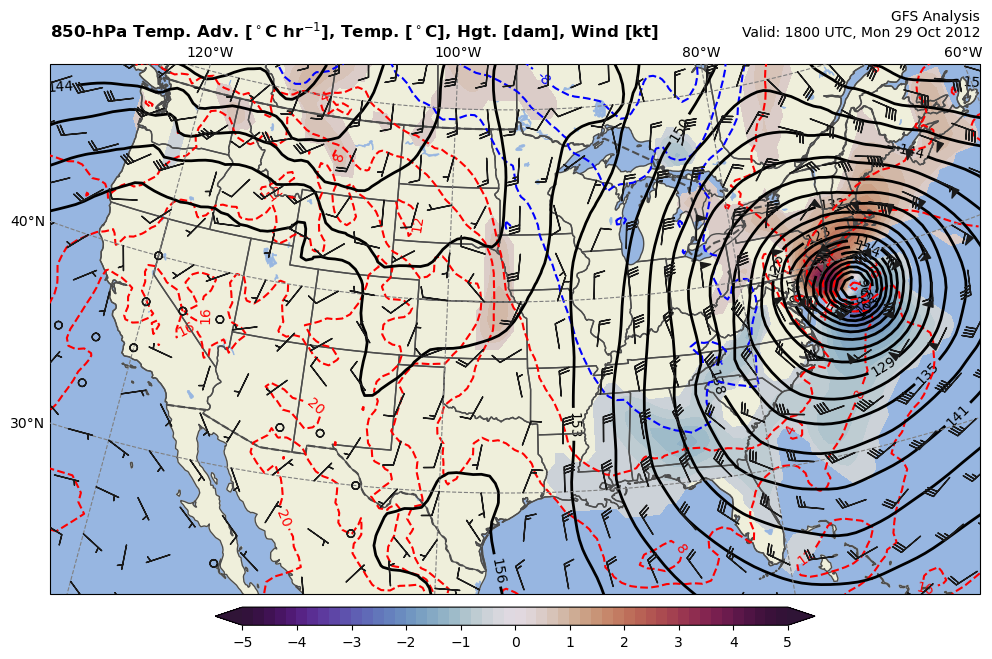

In [6]:
cart_proj=ccrs.LambertConformal(central_longitude=-96.0) #Standard projection options can be changed using arguments here
fig,ax=plt.subplots(dpi=100,figsize=(12,9),subplot_kw={'projection':cart_proj})

#Plot geography (doesn't download again after the first time it is cached)
geog_scale='50m' #Options: 10m, 50m, 110 m (fine, medium, coarse)
geog_color='0.3' #See options here: https://matplotlib.org/3.3.0/tutorials/colors/colors.html and https://matplotlib.org/3.3.0/gallery/color/named_colors.html
geog_lw=1.5 #Set linewidth of country borders
ax.add_feature(cfeature.OCEAN.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(cfeature.BORDERS.with_scale(geog_scale),linewidth=geog_lw,edgecolor=geog_color,zorder=3.1,linestyle='--')
ax.add_feature(cfeature.COASTLINE.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3)
ax.add_feature(cfeature.STATES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3.1)
ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor='face',facecolor=cfeature.COLORS['water']) #Filled lakes, no outlines 
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor=geog_color,facecolor='none',zorder=3) #Lake outlines only
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor=geog_color,facecolor=cfeature.COLORS['water'],zorder=3) #Lake outlines with fill
#ax.add_feature(cfeature.RIVERS.with_scale(geog_scale),linewidth=geog_lw) #Filled rivers, no outlines 

#ax.add_feature(USCOUNTIES.with_scale('20m'),edgecolor='darkorange',zorder=2.9,linewidth=geog_lw-1.2) #US counties

#Good extent for CONUS plot using LambertConformal projection
ax.set_extent([-121,-70,22,50]) #lonmin, lonmax, latmin, latmax of plot extent

#Optional: plot lat/lon lines (only recently available in cartopy, need cartopy version 0.18+)
gl=ax.gridlines(draw_labels=True, dms=True,x_inline=False,y_inline=False,linestyle='--',color='0.5',zorder=4)
gl.xlocator=mpl.ticker.FixedLocator(np.arange(-120,59,20)) #Lat/lon lines for CONUS
gl.ylocator=mpl.ticker.FixedLocator(np.arange(30,51,10))
gl.bottom_labels=False
gl.right_labels=False
gl.rotate_labels=None

#Plot temperature advection as fill, converting to units of \delta C per hour
lons=temp.lon.values
lats=temp.lat.values
cf_levels=np.arange(-5,5.1,0.2)
tadv=mpcalc.smooth_gaussian(tadv, 2) #Smooth advection a little
#Mask temperature advection values near zero before plotting
tadv_ma=np.ma.masked_where(np.absolute((tadv.to(units('delta_degC/hour'))).magnitude) < 0.4, (tadv.to(units('delta_degC/hour'))).magnitude)
pc=ax.contourf(lons,lats,tadv_ma,levels=cf_levels,cmap=plt.cm.twilight_shifted,transform=ccrs.PlateCarree(),zorder=2.5,extend='both')

#plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30) #vertical colorbar on right
cbar=plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30,orientation='horizontal') #horizontal colorbar at bottom
cbar.set_ticks(cf_levels[::5]) #Override default tick locations for cleaner colorbar

#Also plot temperature contours
#Option 1: plot temperature in a single color
co_levels=np.arange(-80,60,4) #Celsius
#co_levels=np.arange(-80,60,2) #Celsius

sigma=2
#Convert from K to C before plotting
#cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(temperature.to(units('degC')),sigma),levels=co_levels,colors='m',linewidths=1.5,linestyles='--',transform=ccrs.PlateCarree(),zorder=4)
#plt.clabel(cont,inline=1,fontsize=10,fmt='%i')

#Option 2: plot temperature in different colors for above and below freezing
co_levels_b=np.arange(-80,1,4) #Celsius
co_levels_r=np.arange(4,60,4) #Celsius
#co_levels_b=np.arange(-80,1,2) #Celsius
#co_levels_r=np.arange(2,60,2) #Celsius

sigma=2
#Convert from K to C before plotting
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(temperature.to(units('degC')),sigma),levels=co_levels_b,colors='b',linewidths=1.5,linestyles='--',transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(temperature.to(units('degC')),sigma),levels=co_levels_r,colors='r',linewidths=1.5,linestyles='--',transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')

#Also plot geopotential height contours
if int(plevel)>500:
    co_levels=np.arange(0,390,3) #decameters (dam)
else:
    co_levels=np.arange(420,996,6) #dam

sigma=5
#Convert from meters to decameters before plotting
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(height.to(units('dam')).magnitude,sigma),levels=co_levels,colors='k',linewidths=2.0,transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')

#Finally, plot wind barbs
skip=5 #set skip=1 to plot all gridpoints
#Convert wind from m/s to knots
ax.barbs(lons[::skip],lats[::skip],u_wind.to(units('kts')).magnitude[::skip,::skip],v_wind.to(units('kts')).magnitude[::skip,::skip],transform=ccrs.PlateCarree(),length=6,color='0.1',zorder=4.5)

#Add plot title
fcst_time=model_init+timedelta(hours=tstep)
model_str='GFS Analysis'
fontsize=12
ax.set_title(f'{plevel}-hPa '+'Temp. Adv. [$^\circ$C hr$^{-1}$], Temp. [$^\circ$C], Hgt. [dam], Wind [kt]',fontweight='bold',loc='left',fontsize=fontsize) #Can use some LaTeX math notation (within $$ commands) for nice formatting of labels
#ax.set_title(f'{model_str}, Init: {model_init:%H%M UTC, %d %b %Y}\n f{tstep}, Valid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
ax.set_title(f'{model_str}\nValid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here

#Uncomment the next 5 lines to save plots
#imgdir='' #uncomment to save plots in current directory
#imgdir='images/' #uncomment to save plots in a subdirectory
#if not os.path.exists(imgdir):
#    os.makedirs(imgdir) #Make directory to store plots if it doesn't already exist
#plt.savefig(imgdir+f'gfs_anl_conus_tadv{plevel}_{fcst_time:%Y%m%d_%H%M}.png',bbox_inches='tight') #Uncomment to save figure

In [7]:
#Next example: plot pressure level wind speed, divergence, temperature, geopotential heights, and wind barbs

#Height, wind components, and temperature are available variables in the dataset, 
#will need to calculate divergence (using MetPy)

plevel=300 #desired pressure level (hPa)
lonoffset=360 #Note that THREDDS server hosts GFS data in degrees east
latmin=20
latmax=55
lonmin=-135+lonoffset
lonmax=-55+lonoffset 
tstep=0 #Forecast hour time step (pretty simple for analysis data with only one time index)

varname='u-component_of_wind_isobaric'
uwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='v-component_of_wind_isobaric'
vwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='Geopotential_height_isobaric'
hgt=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='Temperature_isobaric'
temp=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
#print (temp) #View attributes of data selected

In [8]:
#Calculate divergence using MetPy

#Convert xarray DataArrays to MetPy arrays with units attached
temperature=units.Quantity(temp.values,temp.units) #using 'units' attribute from xarray DataArray to give to MetPy's unit handler
u_wind=units.Quantity(uwind.values,uwind.units)
v_wind=units.Quantity(vwind.values,uwind.units)
height=units.Quantity(hgt.values,hgt.units)

dx,dy=mpcalc.lat_lon_grid_deltas(temp.lon.values,temp.lat.values) #calculate spacing between 1x1 degree lat/lon gridpoints

#Calculate divergence using MetPy function
div=mpcalc.divergence(u_wind, v_wind, dx, dy, dim_order='yx')

Text(1.0, 1.0, 'GFS Analysis\nValid: 1800 UTC, Mon 29 Oct 2012')

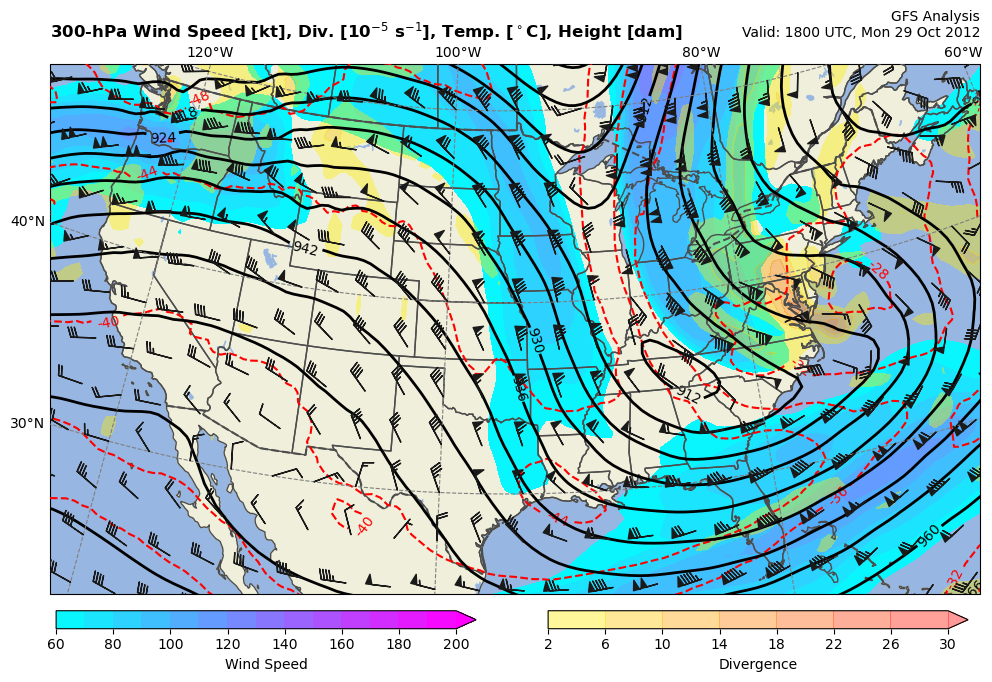

In [9]:
cart_proj=ccrs.LambertConformal(central_longitude=-96.0) #Standard projection options can be changed using arguments here
fig,ax=plt.subplots(dpi=100,figsize=(12,9),subplot_kw={'projection':cart_proj})

#Plot geography (doesn't download again after the first time it is cached)
geog_scale='50m' #Options: 10m, 50m, 110 m (fine, medium, coarse)
geog_color='0.3' #See options here: https://matplotlib.org/3.3.0/tutorials/colors/colors.html and https://matplotlib.org/3.3.0/gallery/color/named_colors.html
geog_lw=1.5 #Set linewidth of country borders
ax.add_feature(cfeature.OCEAN.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(cfeature.BORDERS.with_scale(geog_scale),linewidth=geog_lw,edgecolor=geog_color,zorder=3.1,linestyle='--')
ax.add_feature(cfeature.COASTLINE.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3)
ax.add_feature(cfeature.STATES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3.1)
ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor='face',facecolor=cfeature.COLORS['water']) #Filled lakes, no outlines 
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor=geog_color,facecolor='none',zorder=3) #Lake outlines only
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor=geog_color,facecolor=cfeature.COLORS['water'],zorder=3) #Lake outlines with fill
#ax.add_feature(cfeature.RIVERS.with_scale(geog_scale),linewidth=geog_lw) #Filled rivers, no outlines 

#ax.add_feature(USCOUNTIES.with_scale('20m'),edgecolor='darkorange',zorder=2.9,linewidth=geog_lw-1.2) #US counties

#Good extent for CONUS plot using LambertConformal projection
ax.set_extent([-121,-70,22,50]) #lonmin, lonmax, latmin, latmax of plot extent

#Optional: plot lat/lon lines (only recently available in cartopy, need cartopy version 0.18+)
gl=ax.gridlines(draw_labels=True, dms=True,x_inline=False,y_inline=False,linestyle='--',color='0.5',zorder=4)
gl.xlocator=mpl.ticker.FixedLocator(np.arange(-120,59,20)) #Lat/lon lines for CONUS
gl.ylocator=mpl.ticker.FixedLocator(np.arange(30,51,10))
gl.bottom_labels=False
gl.right_labels=False
gl.rotate_labels=None

#Plot wind speed as fill
lons=temp.lon.values
lats=temp.lat.values
#calculate wind speed from components, convert to kts
wspd_kts=(u_wind.to(units('kts')).magnitude**2. + v_wind.to(units('kts')).magnitude**2.)**0.5
cf_levels=np.arange(60,201,10)
pc=ax.contourf(lons,lats,wspd_kts,levels=cf_levels,cmap=plt.cm.cool,transform=ccrs.PlateCarree(),zorder=2.5,extend='max')

#plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30) #vertical colorbar on right
#plt.colorbar(pc,shrink=0.45,pad=0.02,aspect=30,orientation='horizontal') #horizontal colorbar at bottom
cax=fig.add_axes([0.13,0.17,0.35,0.02]) #Add custom colorbar axis so I can plot two colorbars at once (this is hard-coded)
plt.colorbar(pc,cax=cax,orientation='horizontal',label='Wind Speed') #horizontal colorbar at bottom

#Also plot divergence as semi-transparent overlay
sigma=4
cf_levels=np.arange(2,34,4) #multiply by 10^5 for easier plotting 
pc2=ax.contourf(lons,lats,mpcalc.smooth_gaussian(div*1e5,sigma),levels=cf_levels,cmap=plt.cm.autumn_r,transform=ccrs.PlateCarree(),zorder=2.5,extend='max',alpha=0.4) #alpha parameter sets transparency (0=transparent, 1=opaque)
#plt.colorbar(pc2,shrink=0.45,pad=0.02,aspect=30,orientation='horizontal',anchor=(0.75,1.0)) #horizontal colorbar at bottom
cax=fig.add_axes([0.54,0.17,0.35,0.02]) #Add a second custom colorbar axis so I can plot two colorbars
plt.colorbar(pc2,cax=cax,orientation='horizontal',label='Divergence') #horizontal colorbar at bottom

#Also plot temperature
co_levels=np.arange(-80,60,4) #Celsius
sigma=2
#Convert from K to C before plotting
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(temperature.to(units('degC')),sigma),levels=co_levels,colors='r',linewidths=1.5,linestyles='--',transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')

#Also plot geopotential heights
if int(plevel)>500:
    co_levels=np.arange(0,390,3) #decameters (dam)
else:
    co_levels=np.arange(420,996,6) #dam

sigma=5
#Convert from meters to decameters before plotting
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(height.to(units('dam')).magnitude,sigma),levels=co_levels,colors='k',linewidths=2.0,transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')

#Finally, plot wind barbs
skip=5 #set skip=1 to plot all gridpoints
#Convert wind from m/s to knots
ax.barbs(lons[::skip],lats[::skip],u_wind.to(units('kts')).magnitude[::skip,::skip],v_wind.to(units('kts')).magnitude[::skip,::skip],transform=ccrs.PlateCarree(),length=6,color='0.1',zorder=4.5)

#Add plot title
fcst_time=model_init+timedelta(hours=tstep)
model_str='GFS Analysis'
fontsize=12
ax.set_title(f'{plevel}-hPa '+'Wind Speed [kt], Div. [10$^{-5}$ s$^{-1}$], Temp. [$^\circ$C], Height [dam]',fontweight='bold',loc='left',fontsize=fontsize) #Can use some LaTeX math notation (within $$ commands) for nice formatting of labels
#ax.set_title(f'{model_str}, Init: {model_init:%H%M UTC, %d %b %Y}\n f{tstep}, Valid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
ax.set_title(f'{model_str}\nValid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
#plt.savefig(imgdir+f'gfs_anl_conus_wind{plevel}_div_{fcst_time:%Y%m%d_%H%M}.png',bbox_inches='tight') #Uncomment to save figure

In [10]:
#Next example: plot differential vorticity advection between two levels, 925 mb vorticity, and 1000-500 thickness
#Heights, winds, and temperature are available variables in the dataset, 
#will need to calculate vorticity advection (using MetPy)

plevel=500 #desired pressure level (hPa) for upper level
lonoffset=360 #Note that THREDDS server hosts GFS data in degrees east
latmin=20
latmax=55
lonmin=-135+lonoffset
lonmax=-55+lonoffset 
tstep=0 #Forecast hour time step (pretty simple for analysis data with only one time index)

varname='u-component_of_wind_isobaric'
uwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='v-component_of_wind_isobaric'
vwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='Geopotential_height_isobaric'
hgt=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='Temperature_isobaric'
temp=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
#print (temp) #View attributes of data selected

plevel2=925 #desired pressure level (hPa) for lower level in vort. adv. calc.
varname='u-component_of_wind_isobaric'
uwind2=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel2*100.)
varname='v-component_of_wind_isobaric'
vwind2=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel2*100.)
varname='Geopotential_height_isobaric'
hgt2=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel2*100.)
varname='Temperature_isobaric'
temp2=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel2*100.)
varname='Geopotential_height_isobaric'
hgt1000=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=1000*100.)

In [11]:
#Calculate vorticity advection using MetPy

#Convert xarray DataArrays to MetPy arrays with units attached
temperature=units.Quantity(temp.values,temp.units) #using 'units' attribute from xarray DataArray to give to MetPy's unit handler
u_wind=units.Quantity(uwind.values,uwind.units)
v_wind=units.Quantity(vwind.values,uwind.units)
height=units.Quantity(hgt.values,hgt.units)

dx,dy=mpcalc.lat_lon_grid_deltas(temp.lon.values,temp.lat.values)

#Smooth temperature and wind field somewhat before calculating vort. adv
temp_sm = mpcalc.smooth_n_point(temperature, 9, 20) #Use nine-point smoother 20 times
uwind_sm = mpcalc.smooth_n_point(u_wind, 9, 20)
vwind_sm = mpcalc.smooth_n_point(v_wind, 9, 20)

#Calculate vorticity at upper level
vort_sm = mpcalc.vorticity(uwind_sm, vwind_sm, dx, dy)

#Calculate vorticity advection using MetPy function
vadv=mpcalc.advection(vort_sm, [uwind_sm, vwind_sm], (dx, dy), dim_order='yx')

#Now do the same for the other pressure level before differencing the two
temperature2=units.Quantity(temp2.values,temp2.units) #using 'units' attribute from xarray DataArray to give to MetPy's unit handler
u_wind2=units.Quantity(uwind2.values,uwind2.units)
v_wind2=units.Quantity(vwind2.values,uwind2.units)

#Smooth temperature and wind field somewhat before calculating vort. adv
temp2_sm = mpcalc.smooth_n_point(temperature2, 9, 20)
uwind2_sm = mpcalc.smooth_n_point(u_wind2, 9, 20)
vwind2_sm = mpcalc.smooth_n_point(v_wind2, 9, 20)

#Calculate vorticity at lower level
vort2 = mpcalc.vorticity(uwind2, vwind2, dx, dy)
vort2_sm = mpcalc.vorticity(uwind2_sm, vwind2_sm, dx, dy)

#Calculate vorticity advection using MetPy function
vadv2=mpcalc.advection(vort2_sm, [uwind2_sm, vwind2_sm], (dx, dy), dim_order='yx')

diff_vadv = vadv - vadv2 #differential vorticity advection between the two specified levels

height1000=units.Quantity(hgt1000.values,hgt1000.units)
thickness=height - height1000 #Also calculate 1000-500 hPa thickness

Text(1.0, 1.0, 'GFS Analysis\nValid: 1800 UTC, Mon 29 Oct 2012')

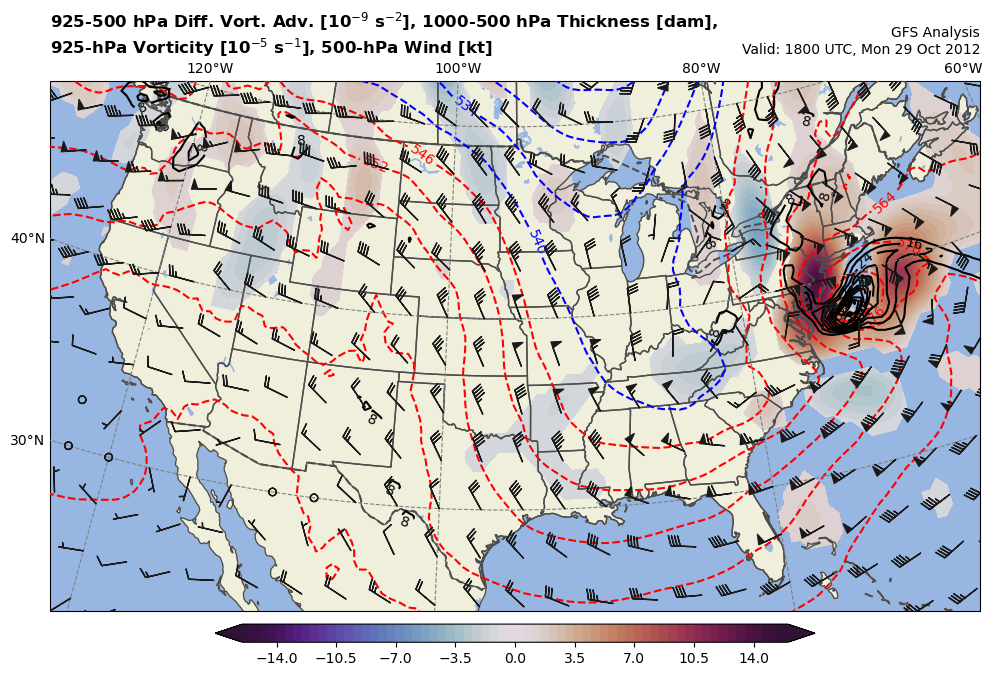

In [12]:
cart_proj=ccrs.LambertConformal(central_longitude=-96.0) #Standard projection options can be changed using arguments here
fig,ax=plt.subplots(dpi=100,figsize=(12,9),subplot_kw={'projection':cart_proj})

#Plot geography (doesn't download again after the first time it is cached)
geog_scale='50m' #Options: 10m, 50m, 110 m (fine, medium, coarse)
geog_color='0.3' #See options here: https://matplotlib.org/3.3.0/tutorials/colors/colors.html and https://matplotlib.org/3.3.0/gallery/color/named_colors.html
geog_lw=1.5 #Set linewidth of country borders
ax.add_feature(cfeature.OCEAN.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(cfeature.BORDERS.with_scale(geog_scale),linewidth=geog_lw,edgecolor=geog_color,zorder=3.1,linestyle='--')
ax.add_feature(cfeature.COASTLINE.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3)
ax.add_feature(cfeature.STATES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3.1)
ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor='face',facecolor=cfeature.COLORS['water']) #Filled lakes, no outlines 
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor=geog_color,facecolor='none',zorder=3) #Lake outlines only
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor=geog_color,facecolor=cfeature.COLORS['water'],zorder=3) #Lake outlines with fill
#ax.add_feature(cfeature.RIVERS.with_scale(geog_scale),linewidth=geog_lw) #Filled rivers, no outlines 

#ax.add_feature(USCOUNTIES.with_scale('20m'),edgecolor='darkorange',zorder=2.9,linewidth=geog_lw-1.2) #US counties

#Good extent for CONUS plot using LambertConformal projection
ax.set_extent([-121,-70,22,50]) #lonmin, lonmax, latmin, latmax of plot extent

#Optional: plot lat/lon lines (only recently available in cartopy, need cartopy version 0.18+)
gl=ax.gridlines(draw_labels=True, dms=True,x_inline=False,y_inline=False,linestyle='--',color='0.5',zorder=4)
gl.xlocator=mpl.ticker.FixedLocator(np.arange(-120,59,20)) #Lat/lon lines for CONUS
gl.ylocator=mpl.ticker.FixedLocator(np.arange(30,51,10))
gl.bottom_labels=False
gl.right_labels=False
gl.rotate_labels=None

#Plot differential vorticity advection as fill, multiplying by 10^9 for easier plotting
lons=temp.lon.values
lats=temp.lat.values
cf_levels=np.arange(-16,16.1,0.5)
diff_vadv=mpcalc.smooth_gaussian(diff_vadv, 2) #Smooth advection a little
#Mask temperature advection values near zero before plotting
diff_vadv_ma=np.ma.masked_where(np.absolute((diff_vadv.magnitude*1e9)) < 1.0, diff_vadv.magnitude*1e9)
pc=ax.contourf(lons,lats,diff_vadv_ma,levels=cf_levels,cmap=plt.cm.twilight_shifted,transform=ccrs.PlateCarree(),zorder=2.5,extend='both')

#plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30) #vertical colorbar on right
plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30,orientation='horizontal') #horizontal colorbar at bottom

#Also plot 1000-500 thickness, as two separate contours (blue for <=540, red for >540)
co_levels_b=np.arange(420,546,6) #dam
co_levels_r=np.arange(546,660,6) #dam
sigma=1
#Convert from K to C before plotting
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(thickness.to(units('dam')),sigma),levels=co_levels_b,colors='b',linewidths=1.5,linestyles='--',transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')
cont2=ax.contour(lons,lats,mpcalc.smooth_gaussian(thickness.to(units('dam')),sigma),levels=co_levels_r,colors='r',linewidths=1.5,linestyles='--',transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont2,inline=1,fontsize=10,fmt='%i')

#Also plot lower level (925 hPa) vorticity, multiplied by 10^5 for plotting purposes
co_levels=np.arange(8,100,8) #s^-1
sigma=1
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(vort2.magnitude*1e5,sigma),levels=co_levels,colors='k',linewidths=1.5,transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')

#Finally, plot upper level wind barbs
skip=5 #set skip=1 to plot all gridpoints
#Convert wind from m/s to knots
ax.barbs(lons[::skip],lats[::skip],u_wind.to(units('kts')).magnitude[::skip,::skip],v_wind.to(units('kts')).magnitude[::skip,::skip],transform=ccrs.PlateCarree(),length=6,color='0.1',zorder=4.5)

#Add plot title
fcst_time=model_init+timedelta(hours=tstep)
model_str='GFS Analysis'
fontsize=12
ax.set_title(f'{plevel2}-{plevel} hPa '+'Diff. Vort. Adv. [10$^{-9}$ s$^{-2}$],'+f' 1000-{plevel} hPa Thickness [dam]'+f',\n{plevel2}-hPa Vorticity '+'[10$^{-5}$ s$^{-1}$],'+f' {plevel}-hPa Wind [kt]',fontweight='bold',loc='left',fontsize=fontsize) #Can use some LaTeX math notation (within $$ commands) for nice formatting of labels
#ax.set_title(f'{model_str}, Init: {model_init:%H%M UTC, %d %b %Y}\n f{tstep}, Valid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
ax.set_title(f'{model_str}\nValid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
#plt.savefig(imgdir+f'gfs_anl_conus_diff_vadv{plevel}_thck_{fcst_time:%Y%m%d_%H%M}.png',bbox_inches='tight') #Uncomment to save figure

In [13]:
#Next example: plot pressure level frontogenesis, temperature, geopotential heights, and wind barbs

#Heights, winds, and temperature are available variables in the dataset, 
#will need to calculate Pettersen frontogenesis (using MetPy)

plevel=850 #desired pressure level (hPa)
lonoffset=360 #Note that THREDDS server hosts GFS data in degrees east
latmin=20
latmax=55
lonmin=-135+lonoffset
lonmax=-55+lonoffset 
tstep=0 #Forecast hour time step (pretty simple for analysis data with only one time index)

varname='u-component_of_wind_isobaric'
uwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='v-component_of_wind_isobaric'
vwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='Geopotential_height_isobaric'
hgt=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='Temperature_isobaric'
temp=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
#print (temp) #View attributes of data selected

In [14]:
#Calculate frontogenesis using MetPy

#Convert xarray Datasets to MetPy arrays with units attached
temperature=units.Quantity(temp.values,temp.units) #using 'units' attribute from xarray DataArray to give to MetPy's unit handler
u_wind=units.Quantity(uwind.values,uwind.units)
v_wind=units.Quantity(vwind.values,uwind.units)
height=units.Quantity(hgt.values,hgt.units)

#Calculate potential temperature
theta=mpcalc.potential_temperature(plevel*units('hPa'),temperature)

#Smooth theta field somewhat before calculating fgen
theta_sm = mpcalc.smooth_n_point(theta, 9, 5)

dx,dy=mpcalc.lat_lon_grid_deltas(temp.lon.values,temp.lat.values)

#Calculate Pettersen frontogenesis
fgen=mpcalc.frontogenesis(theta_sm, u_wind, v_wind, dx, dy, dim_order='yx')

Text(1.0, 1.0, 'GFS Analysis\nValid: 1800 UTC, Mon 29 Oct 2012')

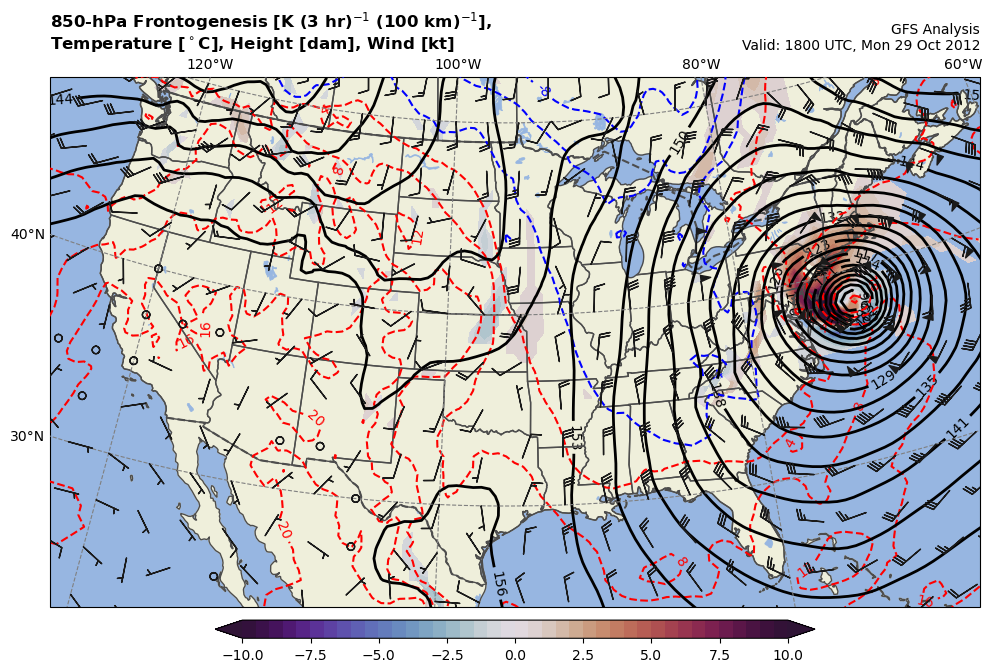

In [15]:
cart_proj=ccrs.LambertConformal(central_longitude=-96.0) #Standard projection options can be changed using arguments here
fig,ax=plt.subplots(dpi=100,figsize=(12,9),subplot_kw={'projection':cart_proj})

#Plot geography (doesn't download again after the first time it is cached)
geog_scale='50m' #Options: 10m, 50m, 110 m (fine, medium, coarse)
geog_color='0.3' #See options here: https://matplotlib.org/3.3.0/tutorials/colors/colors.html and https://matplotlib.org/3.3.0/gallery/color/named_colors.html
geog_lw=1.5 #Set linewidth of country borders
ax.add_feature(cfeature.OCEAN.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(cfeature.BORDERS.with_scale(geog_scale),linewidth=geog_lw,edgecolor=geog_color,zorder=3.1,linestyle='--')
ax.add_feature(cfeature.COASTLINE.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3)
ax.add_feature(cfeature.STATES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3.1)
ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor='face',facecolor=cfeature.COLORS['water']) #Filled lakes, no outlines 
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor=geog_color,facecolor='none',zorder=3) #Lake outlines only
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor=geog_color,facecolor=cfeature.COLORS['water'],zorder=3) #Lake outlines with fill
#ax.add_feature(cfeature.RIVERS.with_scale(geog_scale),linewidth=geog_lw) #Filled rivers, no outlines 

#ax.add_feature(USCOUNTIES.with_scale('20m'),edgecolor='darkorange',zorder=2.9,linewidth=geog_lw-1.2) #US counties

#Good extent for CONUS plot using LambertConformal projection
ax.set_extent([-121,-70,22,50]) #lonmin, lonmax, latmin, latmax of plot extent

#Optional: plot lat/lon lines (only recently available in cartopy, need cartopy version 0.18+)
gl=ax.gridlines(draw_labels=True, dms=True,x_inline=False,y_inline=False,linestyle='--',color='0.5',zorder=4)
gl.xlocator=mpl.ticker.FixedLocator(np.arange(-120,59,20)) #Lat/lon lines for CONUS
gl.ylocator=mpl.ticker.FixedLocator(np.arange(30,51,10))
gl.bottom_labels=False
gl.right_labels=False
gl.rotate_labels=None

#Plot frontogenesis as fill, converting to units of K per 3hr per 100 km for easier plotting
lons=temp.lon.values
lats=temp.lat.values
cf_levels=np.arange(-10,10.1,0.5)
#pc=ax.contourf(lons,lats,(100.*3.)*fgen.to(units('K/hr/km'),levels=cf_levels,cmap=plt.cm.twilight_shifted,transform=ccrs.PlateCarree(),zorder=2.5,extend='both')

#Mask frontogenesis values near zero before plotting
fgen_ma=np.ma.masked_where(np.absolute((100.*3.)*(fgen.to(units('K/hr/km')).magnitude)) < 0.5, (100.*3.)*(fgen.to(units('K/hr/km')).magnitude))
pc=ax.contourf(lons,lats,fgen_ma,levels=cf_levels,cmap=plt.cm.twilight_shifted,transform=ccrs.PlateCarree(),zorder=2.5,extend='both')

#plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30) #vertical colorbar on right
plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30,orientation='horizontal') #horizontal colorbar at bottom

#Also plot temperature contours
#Option 1: plot temperature in a single color
co_levels=np.arange(-80,60,4) #Celsius
sigma=2
#Convert from K to C before plotting
#cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(temperature.to(units('degC')),sigma),levels=co_levels,colors='m',linewidths=1.5,linestyles='--',transform=ccrs.PlateCarree(),zorder=4)
#plt.clabel(cont,inline=1,fontsize=10,fmt='%i')

#Option 2: plot temperature in different colors for above and below freezing
co_levels_b=np.arange(-80,1,4) #dam
co_levels_r=np.arange(4,60,4) #dam
sigma=2
#Convert from K to C before plotting
#print (thickness.to(units('dam')))
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(temperature.to(units('degC')),sigma),levels=co_levels_b,colors='b',linewidths=1.5,linestyles='--',transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')
cont2=ax.contour(lons,lats,mpcalc.smooth_gaussian(temperature.to(units('degC')),sigma),levels=co_levels_r,colors='r',linewidths=1.5,linestyles='--',transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont2,inline=1,fontsize=10,fmt='%i')

#Also plot geopotential heights
if int(plevel)>500:
    co_levels=np.arange(0,390,3) #decameters (dam)
else:
    co_levels=np.arange(420,996,6) #dam

sigma=5
#Convert from meters to decameters before plotting
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(height.to(units('dam')).magnitude,sigma),levels=co_levels,colors='k',linewidths=2.0,transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')

#Finally, plot wind barbs
skip=5 #set skip=1 to plot all gridpoints
#Convert wind from m/s to knots
ax.barbs(lons[::skip],lats[::skip],u_wind.to(units('kts')).magnitude[::skip,::skip],v_wind.to(units('kts')).magnitude[::skip,::skip],transform=ccrs.PlateCarree(),length=6,color='0.1',zorder=4.5)

#Add plot title
fcst_time=model_init+timedelta(hours=tstep)
model_str='GFS Analysis'
fontsize=12
ax.set_title(f'{plevel}-hPa '+'Frontogenesis [K (3 hr)$^{-1}$ (100 km)$^{-1}$],\nTemperature [$^\circ$C], Height [dam], Wind [kt]',fontweight='bold',loc='left',fontsize=fontsize) #Can use some LaTeX math notation (within $$ commands) for nice formatting of labels
#ax.set_title(f'{model_str}, Init: {model_init:%H%M UTC, %d %b %Y}\n f{tstep}, Valid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
ax.set_title(f'{model_str}\nValid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
#plt.savefig(imgdir+f'gfs_anl_conus_fgen{plevel}_temp_{fcst_time:%Y%m%d_%H%M}.png',bbox_inches='tight') #Uncomment to save figure

In [16]:
#Next example: plot integrated vapor transport with component vectors, and MSLP
#This isn't a function available in MetPy but I coded it up myself a while ago
#Requires horizontal wind components and mixing ratio at several layers

#Heights, winds, temperature are available variables in the dataset, 
#will need to calculate mixing ratio from RH

plevels=np.arange(200,1001,100) #desired pressure levels (hPa)
lonoffset=360 #Note that THREDDS server hosts GFS data in degrees east
latmin=20
latmax=55
lonmin=-135+lonoffset
lonmax=-55+lonoffset 
tstep=0 #Forecast hour time step (pretty simple for analysis data with only one time index)

varname='u-component_of_wind_isobaric'
uwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevels*100.)
varname='v-component_of_wind_isobaric'
vwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevels*100.)
varname='Geopotential_height_isobaric'
hgt=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevels*100.)
varname='Temperature_isobaric'
temp=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevels*100.)
varname='Relative_humidity_isobaric'
rh=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric5=plevels*100.)
varname='MSLP_Eta_model_reduction_msl'
mslp=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax))
#print (temp) #View attributes of data selected

In [17]:
#Calculate mixing ratio using MetPy

#Convert xarray DataArrays to MetPy arrays with units attached
temperature=units.Quantity(temp.values,temp.units)
u_wind=units.Quantity(uwind.values,uwind.units)
v_wind=units.Quantity(vwind.values,uwind.units)
relative_humidity=units.Quantity(rh.values,'percent')
msl_pressure=units.Quantity(mslp.values,mslp.units)

#mixing_ratio=mpcalc.mixing_ratio_from_relative_humidity(relative_humidity,temperature,plevels*units('hPa'))

#Mixing ratio formula only works on one level at a time, so need to loop through each pressure level
mixing_ratio=[]
for i,plev in enumerate(rh.isobaric5.values):
    #print (i,plev)
    mixr_lev=mpcalc.mixing_ratio_from_relative_humidity(relative_humidity[i,:,:],temperature[i,:,:],plev*units('Pa'))
    #print (mixr_lev)
    mixing_ratio.append(mixr_lev)

#Units are lost when combining array, so have to add them again
mixing_ratio=units.Quantity(np.array(mixing_ratio),mixr_lev.units)

#Now calculate IVT
def integrated_vapor_transport(mixing_ratio,u_wind,v_wind,dp=10000.):
    #From default units, mixing ratio should be in kg/kg and u/v wind should be in m/s
    #Arrays should be ordered in z, y, z here
    qu=mixing_ratio * u_wind
    qv= mixing_ratio * v_wind
    #IVT=-(1/gravity) integral (from p_0 to p) of qV where V is the vector wind
    #Here, integrating from p to p_0 and removing the minus sign out front, because pressure levels are in descending order (increasing) in this GFS dataset
    ivt_x = (1./9.80665) * np.trapz(qu.magnitude, dx=dp, axis=0) #Do trapezoidal approximation to vertical integral
    ivt_y = (1./9.80665) * np.trapz(qv.magnitude, dx=dp, axis=0) #Do trapezoidal approximation to vertical integral
    ivt_x=units.Quantity(ivt_x,units('kg/m/s')) #return correct units
    ivt_y=units.Quantity(ivt_y,units('kg/m/s')) #return correct units
    return (ivt_x, ivt_y)
    
ivt_x,ivt_y=integrated_vapor_transport(mixing_ratio,u_wind,v_wind)
ivt_mag=(ivt_x.magnitude**2.+ivt_y.magnitude**2.)**0.5 #Calculate magnitude of IVT from components

Text(1.0, 1.0, 'GFS Analysis\nValid: 1800 UTC, Mon 29 Oct 2012')

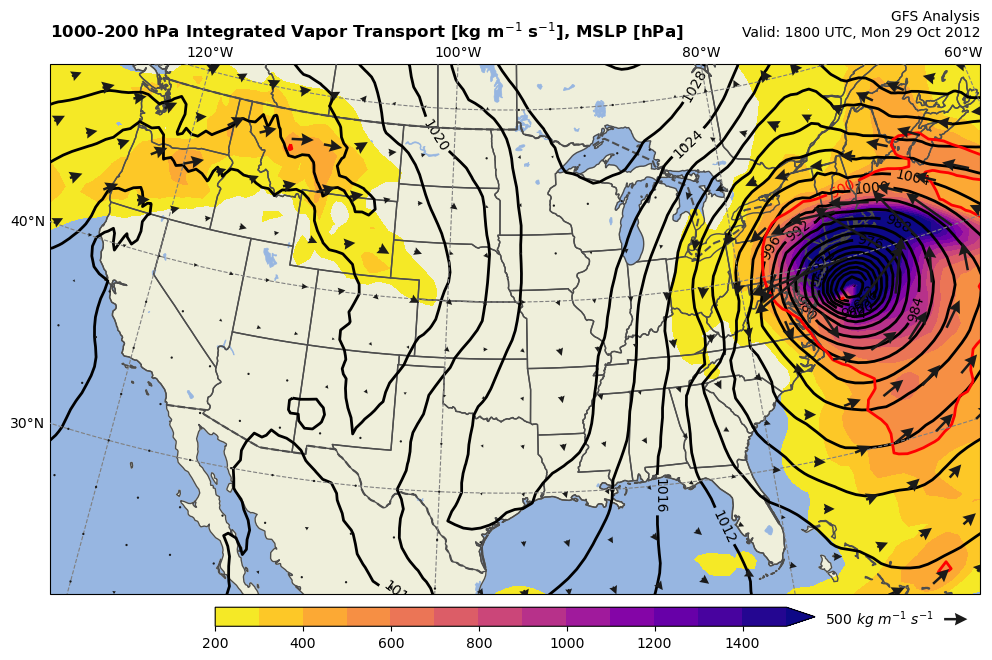

In [18]:
cart_proj=ccrs.LambertConformal(central_longitude=-96.0) #Standard projection options can be changed using arguments here
fig,ax=plt.subplots(dpi=100,figsize=(12,9),subplot_kw={'projection':cart_proj})

#Plot geography (doesn't download again after the first time it is cached)
geog_scale='50m' #Options: 10m, 50m, 110 m (fine, medium, coarse)
geog_color='0.3' #See options here: https://matplotlib.org/3.3.0/tutorials/colors/colors.html and https://matplotlib.org/3.3.0/gallery/color/named_colors.html
geog_lw=1.5 #Set linewidth of country borders
ax.add_feature(cfeature.OCEAN.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(cfeature.BORDERS.with_scale(geog_scale),linewidth=geog_lw,edgecolor=geog_color,zorder=3.1,linestyle='--')
ax.add_feature(cfeature.COASTLINE.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3)
ax.add_feature(cfeature.STATES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3.1)
ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor='face',facecolor=cfeature.COLORS['water']) #Filled lakes, no outlines 
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor=geog_color,facecolor='none',zorder=3) #Lake outlines only
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor=geog_color,facecolor=cfeature.COLORS['water'],zorder=3) #Lake outlines with fill
#ax.add_feature(cfeature.RIVERS.with_scale(geog_scale),linewidth=geog_lw) #Filled rivers, no outlines 

#ax.add_feature(USCOUNTIES.with_scale('20m'),edgecolor='darkorange',zorder=2.9,linewidth=geog_lw-1.2) #US counties

#Good extent for CONUS plot using LambertConformal projection
ax.set_extent([-121,-70,22,50]) #lonmin, lonmax, latmin, latmax of plot extent

#Optional: plot lat/lon lines (only recently available in cartopy, need cartopy version 0.18+)
gl=ax.gridlines(draw_labels=True, dms=True,x_inline=False,y_inline=False,linestyle='--',color='0.5',zorder=4)
gl.xlocator=mpl.ticker.FixedLocator(np.arange(-120,59,20)) #Lat/lon lines for CONUS
gl.ylocator=mpl.ticker.FixedLocator(np.arange(30,51,10))
gl.bottom_labels=False
gl.right_labels=False
gl.rotate_labels=None

#Plot IVT as fill
lons=temp.lon.values
lats=temp.lat.values
cf_levels=np.arange(200,1501,100)
sigma=2
pc=ax.contourf(lons,lats,mpcalc.smooth_gaussian(ivt_mag,sigma),levels=cf_levels,cmap=plt.cm.plasma_r,transform=ccrs.PlateCarree(),zorder=2.5,extend='max')

#plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30) #vertical colorbar on right
plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30,orientation='horizontal') #horizontal colorbar at bottom

#Also plot MSLP contours
co_levels=np.arange(920,1080,4) #hPa
sigma=2
#Convert from Pa to hPa before plotting
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(msl_pressure.to(units('hPa')),sigma),levels=co_levels,colors='k',linewidths=2.0,transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')
    
#Also plot a single red contour of IVT for reference
co_levels=[500] #kg/m/s
sigma=2
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(ivt_mag,sigma),levels=co_levels,colors='r',linewidths=2.0,transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')

#Finally, plot IVT vectors
#Need to remove some points otherwise plot will be covered with arrows, determine interval of gridpoints to skip
skip=5 #set skip=1 to plot all gridpoints
quiv=ax.quiver(lons[::skip],lats[::skip],ivt_x.magnitude[::skip,::skip],ivt_y.magnitude[::skip,::skip],transform=ccrs.PlateCarree(),scale=2e4,headwidth=5,color='0.1',zorder=4.5)
qk_val=500
qk=plt.quiverkey(quiv,0.87,0.225,qk_val,'$'+str(qk_val)+'\ kg\ m^{-1}\ s^{-1}$',coordinates='figure',labelpos='W') #Add key for vector plot at lower right, beside colorbar

#Add plot title
fcst_time=model_init+timedelta(hours=tstep)
model_str='GFS Analysis'
fontsize=12
ax.set_title(f'{plevels[-1]}-{plevels[0]} hPa '+'Integrated Vapor Transport [kg m$^{-1}$ s$^{-1}$], MSLP [hPa]',fontweight='bold',loc='left',fontsize=fontsize) #Can use some LaTeX math notation (within $$ commands) for nice formatting of labels
#ax.set_title(f'{model_str}, Init: {model_init:%H%M UTC, %d %b %Y}\n f{tstep}, Valid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
ax.set_title(f'{model_str}\nValid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
#plt.savefig(imgdir+f'gfs_anl_conus_ivt_mslp_{fcst_time:%Y%m%d_%H%M}.png',bbox_inches='tight') #Uncomment to save figure

In [19]:
#One final example, Q-vectors (adapted from Kevin Goebbert, source: https://unidata.github.io/python-training/gallery/850hpa_qvectors/)
#Check out the Unidata Python gallery for more examples: https://unidata.github.io/python-training/gallery/gallery-home/
#Also, the list of calculations MetPy can do might give some other ideas: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html

#Get variables, will need to calculate Q-vectors using MetPy
plevel=700 #desired pressure level (hPa)
lonoffset=360 #Note that THREDDS server hosts GFS data in degrees east
latmin=20
latmax=55
lonmin=-135+lonoffset
lonmax=-55+lonoffset 
tstep=0 #Forecast hour time step (pretty simple for analysis data with only one time index)

varname='u-component_of_wind_isobaric'
uwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='v-component_of_wind_isobaric'
vwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='Geopotential_height_isobaric'
hgt=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='Temperature_isobaric'
temp=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
#print (temp) #View attributes of data selected

In [20]:
#Convert xarray DataArrays to MetPy arrays with units attached
height=units.Quantity(hgt.values,hgt.units)
temperature=units.Quantity(temp.values,temp.units)
u_wind=units.Quantity(uwind.values,uwind.units)
v_wind=units.Quantity(vwind.values,vwind.units)

#Q-vectors can be quite finicky to calculate and plot
#Depends on resolution of original dataset, and can take some trial and error with smoothing to get a nice plot

#Smooth data using a nine-point filter applied 50 times to isolate the large-scale synoptic signal and remove mesoscale noise
hgt_sm = mpcalc.smooth_n_point(height, 9, 50)
temp_sm = mpcalc.smooth_n_point(temperature, 9, 50)
#uwind_sm = mpcalc.smooth_n_point(u_wind, 9, 50)
#vwind_sm = mpcalc.smooth_n_point(v_wind, 9, 50)

#Calculate grid spacing
dx,dy=mpcalc.lat_lon_grid_deltas(temp.lon.values,temp.lat.values)

#MetPy needs 2-D lat/lon grid for coriolis parameter calculation
lon2d, lat2d = np.meshgrid(temp.lon.values,temp.lat.values)

#Calculate the geostrophic wind components
f = mpcalc.coriolis_parameter(lat2d*units('degrees'))
ugeo_sm, vgeo_sm = mpcalc.geostrophic_wind(hgt_sm, f, dx, dy, dim_order='yx')

#Calculate the Q-vector components
uqvect, vqvect = mpcalc.q_vector(ugeo_sm, vgeo_sm, temp_sm, plevel*units.hPa, dx, dy)
#uqvect, vqvect = mpcalc.q_vector(uwind_sm, vwind_sm, temp_sm, plevel*units.hPa, dx, dy)

#Compute the divergence of the Q-vectors above,
#calculate the right hand side of the Q-vector form of the QG Omega equation (Hoskins et al. 1978)
q_conv = -2*mpcalc.divergence(uqvect, vqvect, dx, dy, dim_order='yx')
q_conv_sm = mpcalc.smooth_gaussian(q_conv, 5) #Smooth convergence field a bit more

Text(1.0, 1.0, 'GFS Analysis\nValid: 1800 UTC, Mon 29 Oct 2012')

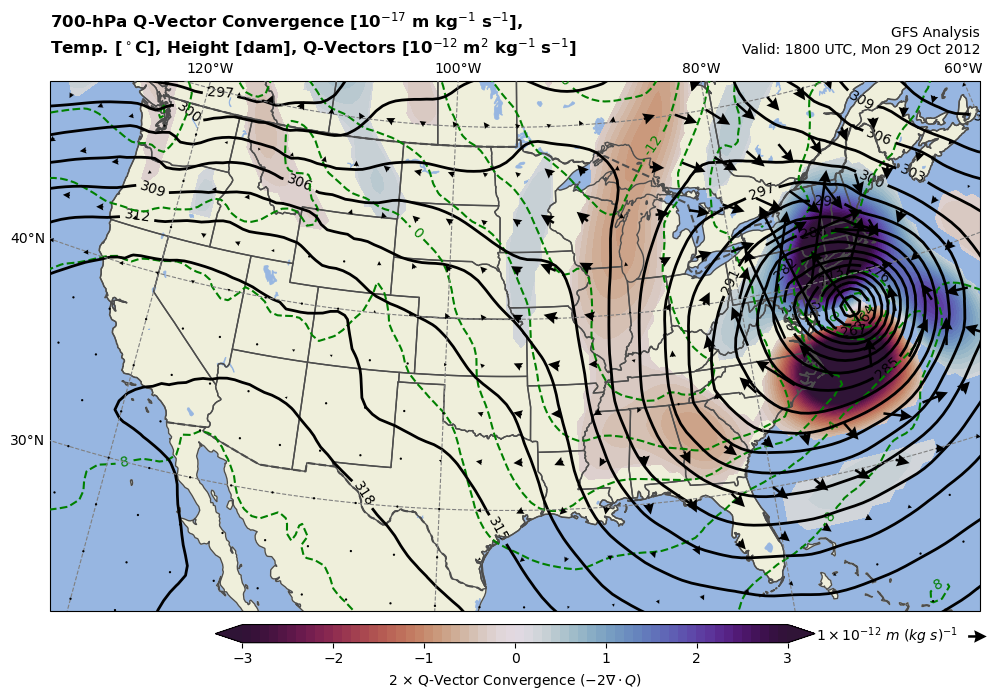

In [21]:
cart_proj=ccrs.LambertConformal(central_longitude=-96.0) #Standard projection options can be changed using arguments here
fig,ax=plt.subplots(dpi=100,figsize=(12,9),subplot_kw={'projection':cart_proj})

#Plot geography (doesn't download again after the first time it is cached)
geog_scale='50m' #Options: 10m, 50m, 110 m (fine, medium, coarse)
geog_color='0.3' #See options here: https://matplotlib.org/3.3.0/tutorials/colors/colors.html and https://matplotlib.org/3.3.0/gallery/color/named_colors.html
geog_lw=1.5 #Set linewidth of country borders
ax.add_feature(cfeature.OCEAN.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(cfeature.BORDERS.with_scale(geog_scale),linewidth=geog_lw,edgecolor=geog_color,zorder=3.1,linestyle='--')
ax.add_feature(cfeature.COASTLINE.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3)
ax.add_feature(cfeature.STATES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3.1)
ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor='face',facecolor=cfeature.COLORS['water']) #Filled lakes, no outlines 
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor=geog_color,facecolor='none',zorder=3) #Lake outlines only
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-1.,edgecolor=geog_color,facecolor=cfeature.COLORS['water'],zorder=3) #Lake outlines with fill
#ax.add_feature(cfeature.RIVERS.with_scale(geog_scale),linewidth=geog_lw) #Filled rivers, no outlines 

#ax.add_feature(USCOUNTIES.with_scale('20m'),edgecolor='darkorange',zorder=2.9,linewidth=geog_lw-1.2) #US counties

#Good extent for CONUS plot using LambertConformal projection
ax.set_extent([-121,-70,22,50]) #lonmin, lonmax, latmin, latmax of plot extent

#Optional: plot lat/lon lines (only recently available in cartopy, need cartopy version 0.18+)
gl=ax.gridlines(draw_labels=True, dms=True,x_inline=False,y_inline=False,linestyle='--',color='0.5',zorder=4)
gl.xlocator=mpl.ticker.FixedLocator(np.arange(-120,59,20)) #Lat/lon lines for CONUS
gl.ylocator=mpl.ticker.FixedLocator(np.arange(30,51,10))
gl.bottom_labels=False
gl.right_labels=False
gl.rotate_labels=None

#Plot q-vectors as vector arrows, multiplying by 10^12 to make plotting easier
lons=temp.lon.values
lats=temp.lat.values
skip=5 #set skip=1 to plot all gridpoints
#Sometimes the q-vectors get wildly long at the edges of the plot, squash this by masking very large +/- values
uqvect_ma=np.ma.masked_where(np.absolute(uqvect.magnitude)*1e12 > 10., uqvect.magnitude*1e12)
vqvect_ma=np.ma.masked_where(np.absolute(vqvect.magnitude)*1e12 > 10., vqvect.magnitude*1e12)
quiv=ax.quiver(lons[::skip],lats[::skip],uqvect_ma[::skip,::skip],vqvect_ma[::skip,::skip],transform=ccrs.PlateCarree(),scale=50,headwidth=5,color='k',zorder=4.5)
qk_val=1
qk=plt.quiverkey(quiv,0.89,0.225,qk_val,'$'+str(qk_val)+r'\times 10^{-12}\ m\ (kg\ s)^{-1}$',coordinates='figure',labelpos='W') #Add key for vector plot

#Plot q-vector convergence as fill, multiplying by 10^17 to make plotting easier
#cf_levels=np.arange(-10.0,10.1,0.2)
cf_levels=np.arange(-3,3.1,0.1)
#Mask q-vector convergence values near zero before plotting
q_conv_ma=np.ma.masked_where(np.absolute(q_conv_sm.magnitude*1e17) < 0.25, q_conv_sm.magnitude*1e17)
pc=ax.contourf(lons,lats,q_conv_ma,levels=cf_levels,cmap=plt.cm.twilight_shifted_r,transform=ccrs.PlateCarree(),zorder=2.5,extend='both') #

#plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30) #vertical colorbar on right
cbar=plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30,orientation='horizontal',label=r'2 $\times$ Q-Vector Convergence ($-2\nabla \cdot Q$)') #horizontal colorbar at bottom
cbar.set_ticks(cf_levels[::10]) #Override default tick locations for cleaner colorbar

#Also plot temperature as dashed contours
co_levels=np.arange(-80,60,4) #Celsius
sigma=5
#Convert from K to C before plotting
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(temperature.to(units('degC')),sigma),levels=co_levels,colors='g',linewidths=1.5,linestyles='--',transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')

#Also plot geopotential heights as solid contours
if int(plevel)>500:
    co_levels=np.arange(0,390,3) #decameters (dam)
else:
    co_levels=np.arange(420,996,6) #dam

sigma=5
#Convert from meters to decameters before plotting
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(height.to(units('dam')),sigma),levels=co_levels,colors='k',linewidths=2.0,transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')

#Add plot title
fcst_time=model_init+timedelta(hours=tstep)
model_str='GFS Analysis'
fontsize=12
ax.set_title(f'{plevel}-hPa '+'Q-Vector Convergence [10$^{-17}$ m kg$^{-1}$ s$^{-1}$],\nTemp. [$^\circ$C], Height [dam], Q-Vectors [10$^{-12}$ m$^2$ kg$^{-1}$ s$^{-1}$]',fontweight='bold',loc='left',fontsize=fontsize) #Can use some LaTeX math notation (within $$ commands) for nice formatting of labels
#ax.set_title(f'{model_str}, Init: {model_init:%H%M UTC, %d %b %Y}\n f{tstep}, Valid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
ax.set_title(f'{model_str}\nValid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
#plt.savefig(imgdir+f'gfs_anl_conus_qvec{plevel}_temp_{fcst_time:%Y%m%d_%H%M}.png',bbox_inches='tight') #Uncomment to save figure